# Car Price Prediction

## Machine Learning Regression Algorithm Selection

*Eduardo Solano Jaime*

*0213663*

*ECID*

*Universidad Panamericana campus Guadalajara*

---

### Objective

The following Notebookaims to build a machine learning regression algorithm in order to predict the price of cars based on a the data set [Car Price Prediction(used cars)](https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars/). Following the checklist provided during class, the proyect will tackle the problem from the begining: including setting the goal of the code, prepare and process the data, feature engineering, odel  building and testing, and final cross validation to determine the optimal method to predict prices.

### Obtain and sample the data

In [87]:
import pandas as pd

dataset = 'car data.csv'
df= pd.read_csv(dataset, sep=',')
names = df.columns
df.sample(3)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
268,brio,2017,4.80,5.80,19000,Petrol,Dealer,Manual,0
279,city,2014,6.25,13.60,40126,Petrol,Dealer,Manual,0
68,corolla altis,2011,4.35,13.74,88000,Petrol,Dealer,Manual,0


### Analysis each feature and its characteristics

In [88]:
print(f'The dataset has a size of {df.shape}')
df.info()

The dataset has a size of (301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [89]:
for name in names:
    print(name, df.loc[:, name].unique()[:min(5, len(df.loc[:, name].unique()))], len(df.loc[:, name].unique()))

Car_Name ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift'] 98
Year [2014 2013 2017 2011 2018] 16
Selling_Price [3.35 4.75 7.25 2.85 4.6 ] 156
Present_Price [5.59 9.54 9.85 4.15 6.87] 148
Driven_kms [27000 43000  6900  5200 42450] 206
Fuel_Type ['Petrol' 'Diesel' 'CNG'] 3
Selling_type ['Dealer' 'Individual'] 2
Transmission ['Manual' 'Automatic'] 2
Owner [0 1 3] 3


We have a total of 8 features + target feature before feature engineering. We can clearly see that some of the columns contain categorical and other numerical data, therefore a preprocessing must be made in order to analyze in depths the dataset to determine wether noise is present and extrat statistical information.

In [90]:
names = df.columns
names

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

Now, before using Pipelines to transform further the date we split it in a 80-20 ratio between test and train. We wont see the test set until the end of the analysis

In [91]:
from sklearn.model_selection import train_test_split

df.columns = [x.replace('_', '') for x in df.columns]
names = df.columns
target = 'PresentPrice'
y = df.loc[:, target]
X = df.loc[:, [x for x in df.columns.values if x!=target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
205,grand i10,2016,5.25,3493,Petrol,Dealer,Manual,1
122,Royal Enfield Bullet 350,2016,1.05,6000,Petrol,Individual,Manual,0
176,Honda Karizma,2011,0.35,30000,Petrol,Individual,Manual,0


### Transform data

For **Categorical data** specific transformations are to be made:
 - Nominal variables
   - *CarName* - LabelEncoder (although I suspect the car name is going to have no correlation with the price)
   - *FuelType* LabelEncoder or OneHotEncoder
   - *Sellingtype* and *Transmission* simple replacement

For **Numerical data** a simple StandardScaler is going to be used since there are no missing values

In [92]:
# Numerical data
numeric = ['Year', 'SellingPrice', 'Drivenkms']

# Binary cata
binary = ['Sellingtype', 'Transmission']

# Easy binary replacements for binary columns
X_train[binary] = df.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
X_test[binary] = df.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})

X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
140,Honda CBR 150,2013,0.60,32000,Petrol,1,0,0
39,sx4,2003,2.25,62000,Petrol,0,0,0
158,Honda Dream Yuga,2017,0.48,8600,Petrol,1,0,0


In [93]:
# pip install category-encoders

In [94]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from category_encoders import BinaryEncoder, OneHotEncoder

# dummy = FunctionTransformer(lambda x: pd.get_dummies(x, drop_first=True), validate=False)

ct = ColumnTransformer(transformers=
                       [('numeric', StandardScaler(), numeric),
                        ('cars', BinaryEncoder(), ['CarName']),
                        ('fuel', OrdinalEncoder(), ['FuelType'])],
                       remainder='passthrough')

X_train_fit = ct.fit_transform(X_train)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit = pd.DataFrame(X_train_fit, columns=columns) # type: ignore
X_test_fit = ct.fit_transform(X_test)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit = pd.DataFrame(X_test_fit, columns=columns) # type: ignore
X_train_fit.sample(5)

,Year,SellingPrice,Drivenkms,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Sellingtype,Transmission,Owner
67,-1.623496,-0.514143,1.463713,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
124,-0.920176,-0.896131,1.378524,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0
186,0.486463,0.149740,-1.096332,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
158,-1.623496,-0.197522,0.922219,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0
3,-1.975156,-0.575425,0.781818,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0


### Extra features

I theorize that the relationship between the year the car was sold and how many kilometers weights heavily. I am adding an extra feature to relate them

In [95]:
X_train_fit['WellKept'] = X_train_fit.loc[:, 'Drivenkms'] * X_train_fit.loc[:, 'Year'] # type: ignore
X_test_fit['WellKept'] = X_test_fit.loc[:, 'Drivenkms'] * X_test_fit.loc[:, 'Year'] # type: ignore

### Correlation Matrix

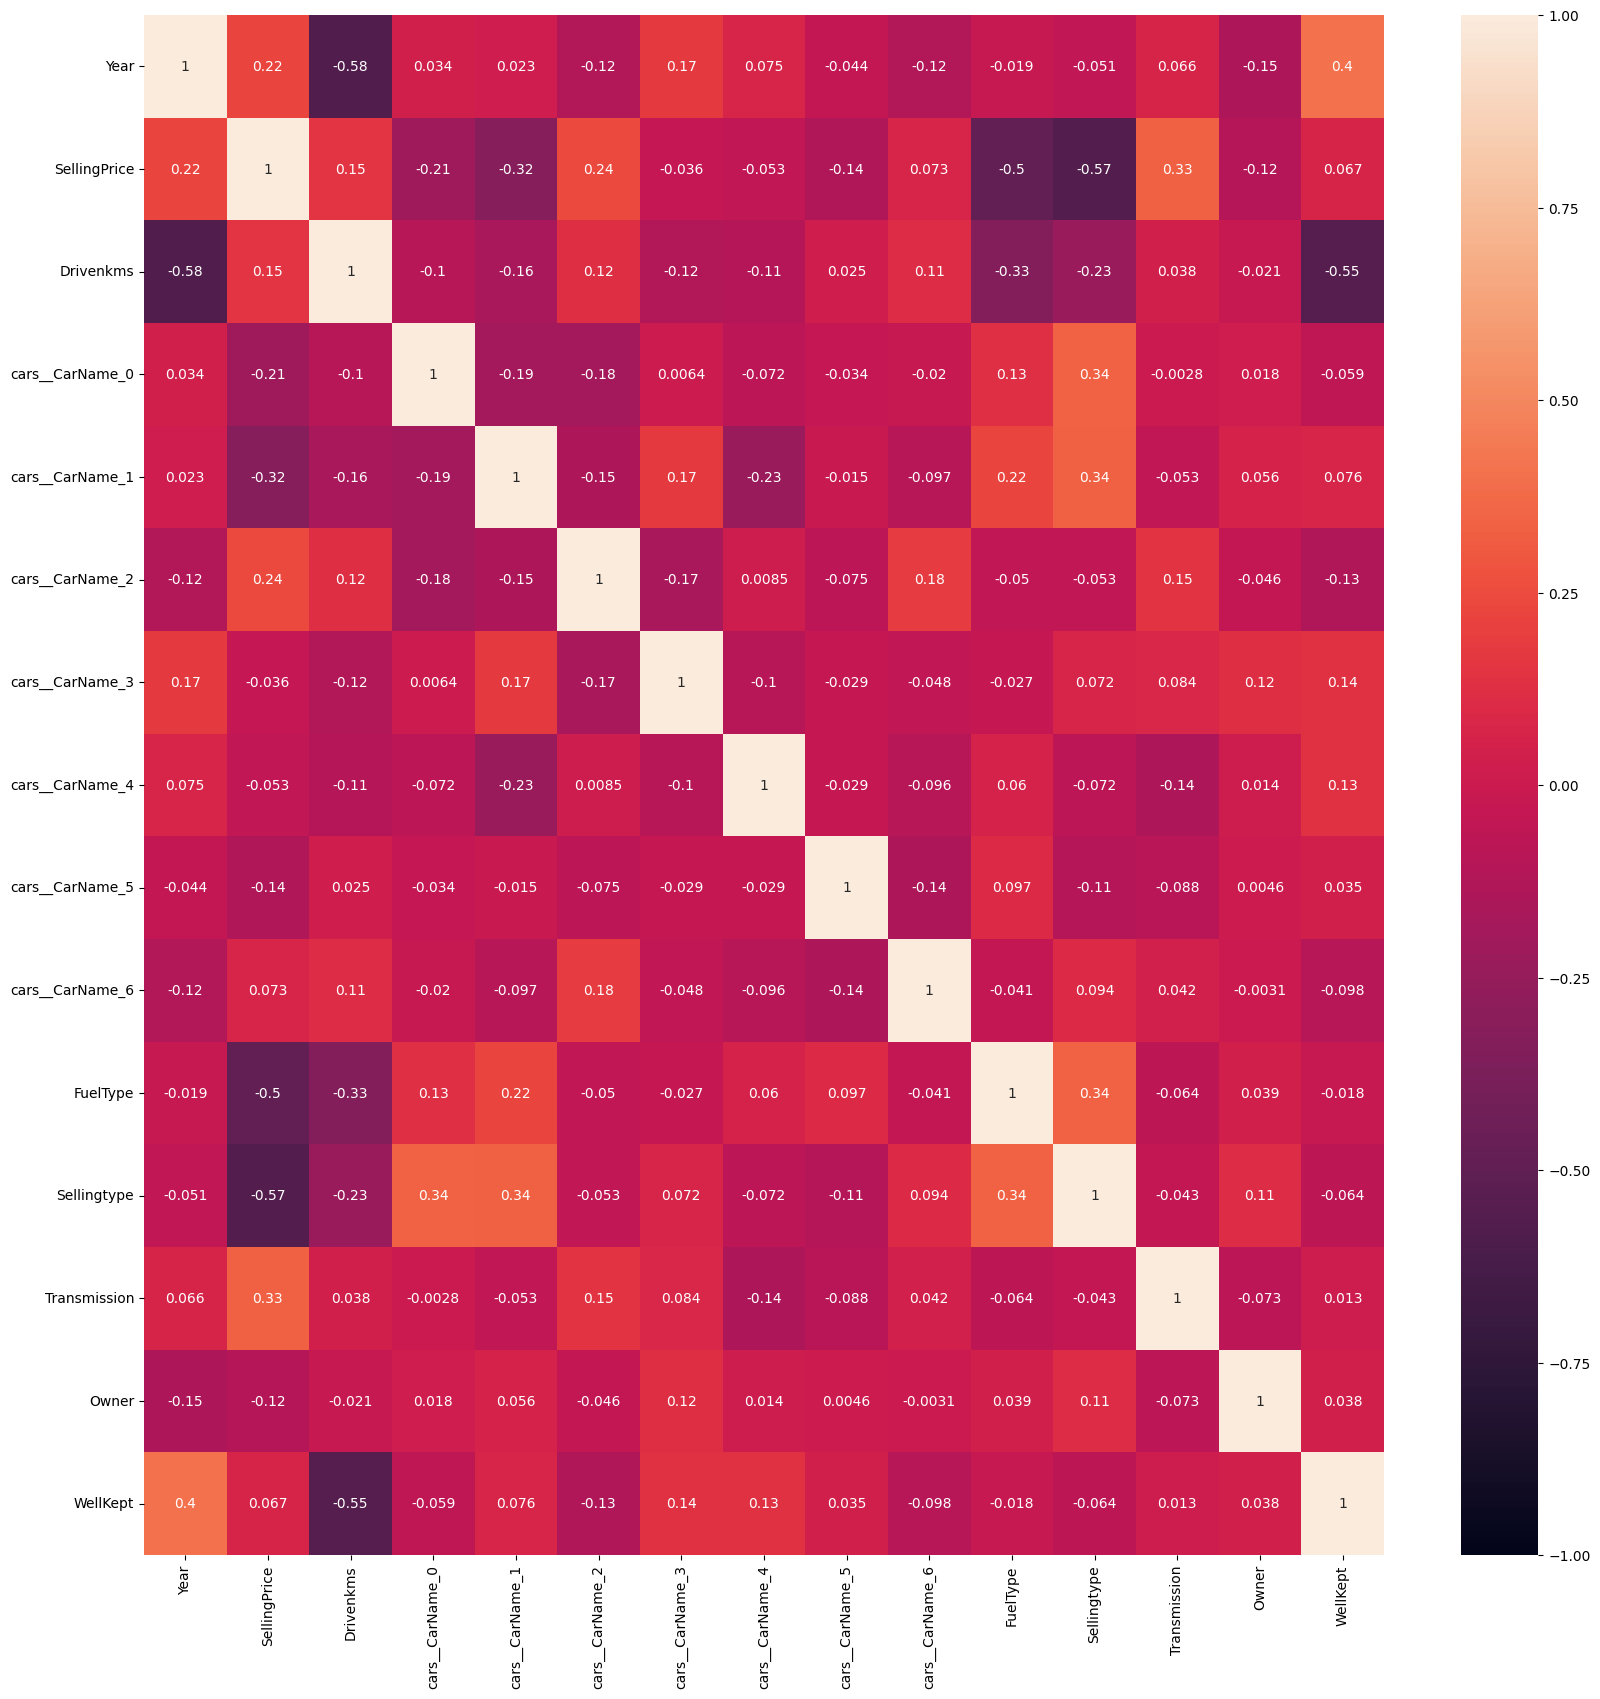

In [96]:
import matplotlib.pyplot as plt
import seaborn as sea

correlation = X_train_fit.corr(method='pearson')
fig1 = plt.figure(figsize=(20,20))
ax = sea.heatmap(correlation, annot=True, vmin=-1, vmax=1)
plt.show()

There are some positively correlated features

Now, feature engineering is needed to remove those higly correlated features

In [97]:
import numpy as np

corr = X_train_fit.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
X_test_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
X_train_fit.shape

(240, 15)

### Shortlist Promising Models

In [98]:
# Get the models

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

models = [LinearRegression(), PolynomialFeatures(include_bias=False), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), SGDRegressor(), KNeighborsRegressor(), BayesianRidge()]

xgb.set_config(verbosity=0)

In [99]:
first_scores = []
for model in models:
    score = 0
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures()
        X_poly = poly_features.fit_transform(X_train_fit)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit, y_train)
        score = model.score(X_train_fit, y_train)
        first_scores.append(score)
    print(f"Score of {score:.5f} was achieved with {model}")

Score of 0.86898 was achieved with LinearRegression()
Score of 0.99233 was achieved with PolynomialFeatures()
Score of 0.86889 was achieved with Ridge()
Score of 0.82031 was achieved with Lasso()
Score of 1.00000 was achieved with DecisionTreeRegressor()


Score of 0.94740 was achieved with RandomForestRegressor()
Score of 0.86513 was achieved with SGDRegressor()
Score of 0.83224 was achieved with KNeighborsRegressor()
Score of 0.86869 was achieved with BayesianRidge()


Before jumping to any conclusions about the performance of the models, I want to try a different feature engineering in which the *CarName* and *FuelType* columns go through a OneHotEncoder
So we change the Transformers and perform everything again

In [100]:
ct2 = ColumnTransformer(transformers=
                       [('numeric', StandardScaler(), numeric),
                        ('category', OneHotEncoder(), ['CarName', 'FuelType'])],
                       remainder='passthrough')

X_train_fit2 = ct2.fit_transform(X_train)
columns2 = numeric + [x for x in list(ct2.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit2 = pd.DataFrame(X_train_fit2, columns=columns2) # type: ignore
X_test_fit2 = ct2.fit_transform(X_test)
columns = numeric + [x for x in list(ct2.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit2 = pd.DataFrame(X_test_fit2, columns=columns) # type: ignore

X_train_fit2['WellKept'] = X_train_fit2.loc[:, 'Drivenkms'] * X_train_fit2.loc[:, 'Year'] # type: ignore
X_test_fit2['WellKept'] = X_test_fit2.loc[:, 'Drivenkms'] * X_test_fit2.loc[:, 'Year'] # type: ignore

corr = X_train_fit2.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop2 = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit2.drop(to_drop2, axis=1, inplace=True) # type: ignore

for model, old_score in zip(models, first_scores):
    if str(model)=='PolynomialFeatures(include_bias=False)':
        model = LinearRegression()
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X_train_fit2)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit2, y_train)
        score = model.score(X_train_fit2, y_train)
    print(f"Score of {score:.5f} was achieved with {model}, a {(old_score-score):.5f} difference")

Score of 0.98348 was achieved with LinearRegression(), a -0.11450 difference
Score of 0.99828 was achieved with PolynomialFeatures(), a -0.12940 difference
Score of 0.94263 was achieved with Ridge(), a -0.12232 difference
Score of 0.82031 was achieved with Lasso(), a 0.17969 difference
Score of 1.00000 was achieved with DecisionTreeRegressor(), a -0.05260 difference
Score of 0.96389 was achieved with RandomForestRegressor(), a -0.09876 difference
Score of 0.91915 was achieved with SGDRegressor(), a -0.08691 difference
Score of 0.84614 was achieved with KNeighborsRegressor(), a 0.02255 difference


Only the *Lasso* and *KNeighborsRegressor* models perform better with the change in the Transformer, and the improvement is not enough to change the data transform.

Therefore we keep the first *X_train_fit*

A function is made to simplify the next entry data

In [140]:
def DataTransform(data: list) -> pd.DataFrame:
  data = [{name:x for name, x in zip([i for i in names if i!=target], data)}]
  X = pd.DataFrame(data)
  X_fit = pd.DataFrame(ct.fit_transform(X))
  X_fit.columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
  X_fit['WellKept'] = X_fit.loc[:, 'Drivenkms'] * X_fit.loc[:, 'Year'] # type: ignore
  X_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
  return X_fit

Now we can pick our top 3 candidate, and according to their scores:
1. **DecisionTreeRegressor()**
2. **PolynomialFeatures()()**
3. **BayesianRidge()**

Identify the most and least important features of each model.

In [102]:
tree = DecisionTreeRegressor()
tree_m = tree.fit(X_train_fit, y_train)

poly_m = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_m.fit_transform(X_train_fit)
poly = LinearRegression().fit(X_poly, y_train)

bayesian = BayesianRidge()
bayesian_m = bayesian.fit(X_train_fit, y_train) # type: ignore

print('Most important:')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[::-1][:5]]}") # type: ignore
print(f"Polynomial: {[poly_m.get_feature_names_out()[i] for i in np.argsort(poly.coef_)[::-1][:5]]}")
print(f"Bayesian: {[list(X_train_fit.columns)[i] for i in np.argsort(bayesian_m.feature_names_in_)[::-1][:5]]}") # type: ignore
print()
print('Least importance')
print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[:5]]}") # type: ignore
print(f"Polynomial: {[poly_m.get_feature_names_out()[i] for i in np.argsort(poly.coef_)[:5]]}")
print(f"Bayesian: {[list(X_train_fit.columns)[i] for i in np.argsort(bayesian_m.feature_names_in_)[:5]]}") # type: ignore

Most important:
Tree: ['SellingPrice', 'Year', 'Drivenkms', 'Transmission', 'cars__CarName_2']
Polynomial: ['cars__CarName_0 FuelType', 'Sellingtype', 'Sellingtype^2', 'Transmission', 'Transmission^2']
Bayesian: ['cars__CarName_6', 'cars__CarName_5', 'cars__CarName_4', 'cars__CarName_3', 'cars__CarName_2']

Least importance
Tree: ['Sellingtype', 'Owner', 'cars__CarName_5', 'cars__CarName_0', 'cars__CarName_1']
Polynomial: ['FuelType Sellingtype', 'cars__CarName_0', 'cars__CarName_0^2', 'FuelType Transmission', 'FuelType']
Bayesian: ['Drivenkms', 'FuelType', 'Owner', 'SellingPrice', 'Sellingtype']


### Fine-Tune the models

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold

repeatedkfold = RepeatedKFold(n_splits=5, n_repeats=25)

param_grids = [
    {'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],  # DecisionTree
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [i for i in range(2, 11)],
    'min_samples_leaf': [1, 2, 4],},
    {'polynomialfeatures__degree': [1, 2, 3],                           # Polynomial Regression
     'polynomialfeatures__include_bias':[True, False]},
    {'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],                         # Bayesian Ridge
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
    ]

regressors = [tree, poly, bayesian]
best_estimator = {}
for regressor, param_grid in zip(regressors[::-1], param_grids[::-1]):
    if str(regressor) == 'LinearRegression()':
        pipeline = Pipeline([
                            ('polynomialfeatures', PolynomialFeatures()),
                            ('linearregression', LinearRegression())
                        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    else:
        grid_search = GridSearchCV(regressor, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    print(f"{regressor}: {grid_search.best_estimator_}")
    print(f"Best params: {grid_search.best_params_}")
    print(f"Score: {grid_search.best_score_*100:,.2f}%", '\n')
    best_estimator[str(regressor)] = grid_search.best_estimator_


BayesianRidge(): BayesianRidge(alpha_2=0.01, lambda_1=0.01)
Best params: {'alpha_1': 1e-06, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 1e-06}
Score: 77.93% 

LinearRegression(): Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linearregression', LinearRegression())])
Best params: {'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': False}
Score: 77.03% 

DecisionTreeRegressor(): DecisionTreeRegressor(criterion='absolute_error', max_depth=40,
                      min_samples_split=5)
Best params: {'criterion': 'absolute_error', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5}
Score: 82.83% 



Now that we have determined the best model is **DecisionTreeRegressor**, let´s try a final change before cross validation: remove the subsets of the least 5 important features and see what happens

In [104]:
from itertools import permutations

tree = best_estimator['DecisionTreeRegressor()']
tree_m = tree.fit(X_train_fit, y_train)

lest_important = [list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[:5]]
perm = [list(permutations(lest_important, i))for i in range(1, len(lest_important)+1)]
subsets = [list(x) for y in perm  for x in y]


In [105]:
names_fit = X_test_fit.columns
best_score = 0
best_subset = []
for subset in subsets:
    temp = X_train_fit.loc[:, names_fit.difference(subset)]
    tree.fit(temp, y_train)
    score = tree.score(temp, y_train)
    if score>best_score:
        best_score = score
        best_subset = subset

print(f"By removing {best_subset} we get the optimal score of {best_score}")
X_train_fit_fout = X_train_fit.loc[:, names_fit.difference(best_subset)]
X_test_fit_fout = X_test_fit.loc[:, names_fit.difference(best_subset)]

By removing ['cars__CarName_6', 'Sellingtype', 'Owner', 'cars__CarName_0'] we get the optimal score of 0.9952460730300409


## Cross Validation

In [106]:
X = pd.concat([X_train_fit_fout, X_test_fit_fout])
y = pd.concat([y_train, y_test])

### KFolding

In [107]:
from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
result = cross_val_score(tree, X, y, cv=kfold)
print(f"La media de los {len(result)} folds es {result.mean():,.3f} con std de {result.std():,.3f}")

La media de los 10 folds es 0.768 con std de 0.191


### Train-test split

In [108]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
tree.fit(X_train, y_train)
result = tree.score(X_test, y_test)
print(f"Score: {result:,.3f}")

Score: 0.869


### Repeated KFolding

In [109]:
from sklearn.model_selection import RepeatedKFold

num_folds = 10
num_repeated = 20
repeatedkfold = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeated)
result = cross_val_score(tree, X, y, cv=repeatedkfold)
print(f"Accuracy: {result.mean()*100:,.2f}%, std {result.std():,.2f}")

Accuracy: 73.32%, std 0.43


Year	SellingPrice	Drivenkms	cars__CarName_0	cars__CarName_1	cars__CarName_2	cars__CarName_3	cars__CarName_4	cars__CarName_5	cars__CarName_6	FuelType	Sellingtype	Transmission	Owner

In [141]:
tocayo = ['raptor', 2022, 1.038, 600000, 'Petrol', 'Individual', 'Automatic', 1]
tocayo = DataTransform(tocayo)
tocayo

,Year,SellingPrice,Drivenkms,cars__CarName_0,FuelType,Sellingtype,Transmission,Owner,WellKept
0,0.0,0.0,0.0,1,0.0,Individual,Automatic,1,0.0
